# Programming a seismic program

This notebook goes with the article

> Bianco, E and M Hall (2015). Programming a seismic program. *CSEG Recorder*, November 2015. 

It's based on some other notebooks, which are themselves accompaniments to various blog posts at [Agile Geoscience](http://www.agilegeoscience.com/blog).

* [Laying out a seismic survey](https://github.com/agile-geoscience/notebooks/blob/master/Laying_out_a_seismic_survey.ipynb)
* [Binning a seismic survey](https://github.com/agile-geoscience/notebooks/blob/master/Binning_a_seismic_survey.ipynb)
* [Seismic acquisition](https://github.com/agile-geoscience/notebooks/blob/master/Seismic_acquisition.ipynb)

## Set up the survey

We'll start with the usual prelims...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import geopandas as gpd
import pandas as pd
from fiona.crs import from_epsg

%matplotlib inline

Define some survey parameters:

In [2]:
xmi = 575000        # Easting of bottom-left corner of grid (m)
ymi = 4710000       # Northing of bottom-left corner (m)
SL = 600            # Source line interval (m)
RL = 600            # Receiver line interval (m)
si = 100            # Source point interval (m)
ri = 100            # Receiver point interval (m)
x = 3000            # x extent of survey (m)
y = 1800            # y extent of survey (m)

epsg = 26911  # A CRS to place it on the earth

Now we can compute some properties of the survey:

In [3]:
rlines = int(y/RL) + 1
slines = int(x/SL) + 1

In [4]:
rperline = int(x/ri) + 2
sperline = int(y/si) + 2

In [5]:
shiftx = -si/2.0
shifty = -ri/2.0

We compute lists of the *x*- and *y*-locations of the receivers and sources with nested loops. We'll use Python's list comprehensions, which are shorthand for `for` loops that generate lists.

In [6]:
rcvrx, rcvry = zip(*[(xmi + rcvr*ri + shiftx, ymi + line*RL - shifty)
                     for line in range(rlines)
                     for rcvr in range(rperline)])

srcx, srcy = zip(*[(xmi + line*SL, ymi + src*si)
                   for line in range(slines)
                   for src in range(sperline)])

In [7]:
rcvrs = [Point(x, y) for x, y in zip(rcvrx, rcvry)]
srcs = [Point(x, y) for x, y in zip(srcx, srcy)]

We can make a list of 'r' and 's' labels then compile into a dataframe.

In [8]:
station_list = ['r']*len(rcvrs) + ['s']*len(srcs)
survey = gpd.GeoDataFrame({'geometry': rcvrs+srcs, 'station': station_list})
survey.crs = from_epsg(epsg)

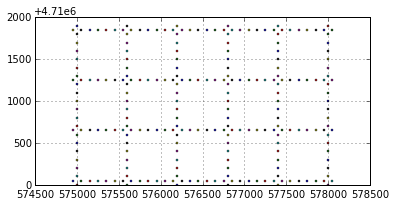

In [9]:
try:
    # Needs geopandas fork: https://github.com/kwinkunks/geopandas
    survey.plot(figsize=(12,12), column='station', colormap="bwr", markersize=20)
except:
    # This will work regardless.
    survey.plot()
plt.grid()
plt.show()

Make a Station ID row, so we can recognize the stations again.

In [10]:
sid = np.arange(len(survey))
survey['SID'] = sid

In [11]:
survey.to_file('data/survey_orig.shp')

## Midpoint calculations

We need midpoints. There is a midpoint between every source-receiver pair.

Hopefully it's not too inelegant to get to the midpoints now that we're using this layout object thing.

In [12]:
midpoint_list = [LineString([r, s]).interpolate(0.5, normalized=True)
                 for r in rcvrs
                 for s in srcs]

As well as knowing the (x,y) of the midpoints, we'd also like to record the distance from each *s* to each live *r* (each *r* in the live patch). This is easy enough to compute:

    Point(x1, y1).distance(Point(x2, y2))
 
Then we can make a list of all the offsets when we count the midpoints into the bins. 

In [13]:
offsets = [r.distance(s)
           for r in rcvrs
           for s in srcs]

In [14]:
azimuths = [np.arctan((r.x - s.x)/(r.y - s.y))
            for r in rcvrs
            for s in srcs]

Make a Geoseries of the midpoints, offsets and azimths:

In [15]:
midpoints = gpd.GeoDataFrame({'geometry': midpoint_list,
                              'offset': offsets,
                              'azimuth': np.degrees(azimuths),
                              })

midpoints[:5]

,azimuth,geometry,offset
0,-45.000000,POINT (574975 4710025),70.710678
1,45.000000,POINT (574975 4710075),70.710678
2,18.434949,POINT (574975 4710125),158.113883
3,11.309932,POINT (574975 4710175),254.950976
4,8.130102,POINT (574975 4710225),353.553391


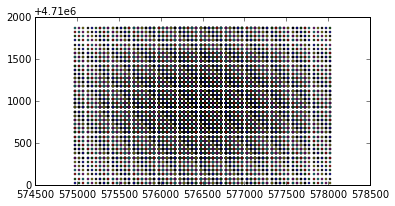

In [17]:
ax = midpoints.plot()

Save to a shapefile if desired. 

In [18]:
# midpoints.to_file('midpoints.shp')

## Spider plot

In [18]:
midpoints['offsetx'] = offsets * np.cos(azimuths)
midpoints['offsety'] = offsets * np.sin(azimuths)
midpoints[:5].offsetx  # Easy!

0     50
1     50
2    150
3    250
4    350
Name: offsetx, dtype: float64

In [19]:
midpoints.ix[3].geometry.x # Less easy :(

574975.0

We need lists (or arrays) to pass into the [matplotlib quiver plot](http://matplotlib.org/examples/pylab_examples/quiver_demo.html). This takes four main parameters: *x, y, u,* and *v*, where *x, y* will be our coordinates, and *u, v* will be the offset vector for that midpoint.

We can get at the GeoDataFrame's attributes easily, but I can't see how to get at the coordinates in the geometry GeoSeries (seems like a user error — it feels like it should be really easy) so I am resorting to this: 

In [20]:
x = [m.geometry.x for i, m in midpoints.iterrows()]
y = [m.geometry.y for i, m in midpoints.iterrows()]

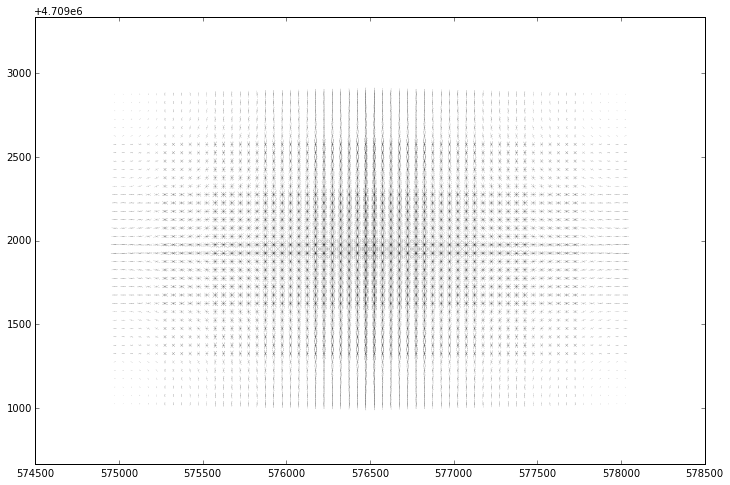

In [21]:
fig = plt.figure(figsize=(12,8))
plt.quiver(x, y, midpoints.offsetx, midpoints.offsety, units='xy', width=0.5, scale=1/0.025, pivot='mid', headlength=0)
plt.axis('equal')
plt.show()

## Bins

The bins are a new geometry, related to but separate from the survey itself, and the midpoints. We will model them as a GeoDataFrame of polygons. The steps are:

1. Compute the bin centre locations with our usual list comprehension trick.
1. Buffer the centres with a square.
1. Gather the buffered polygons into a GeoDataFrame.

In [22]:
# Factor to shift the bins relative to source and receiver points
jig = si / 4.
bin_centres = gpd.GeoSeries([Point(xmi + 0.5*r*ri + jig, ymi + 0.5*s*si + jig)
                             for r in range(2*rperline - 3)
                             for s in range(2*sperline - 2)
                            ])

# Buffers are diamond shaped so we have to scale and rotate them.
scale_factor = np.sin(np.pi/4.)/2.
bin_polys = bin_centres.buffer(scale_factor*ri, 1).rotate(-45)
bins = gpd.GeoDataFrame(geometry=bin_polys)

bins[:3]

,geometry
0,"POLYGON ((575050 4710000, 575000 4710000, 5750..."
1,"POLYGON ((575050 4710050, 575000 4710050, 5750..."
2,"POLYGON ((575050 4710100, 574999.9999999995 47..."


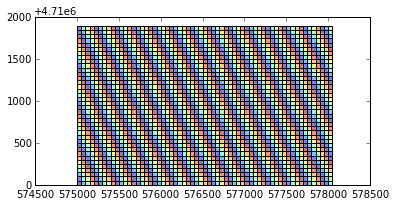

In [23]:
ax = bins.plot()

## Spatial join

Thank you to Jake Wasserman and Kelsey Jordahl for this code snippet, and many pointers. 

This takes about 20 seconds to run on my iMac, compared to something close to 30 minutes for the old nested loops. 

In [24]:
def bin_the_midpoints(bins, midpoints):
    b = bins.copy()
    m = midpoints.copy()
    reindexed = b.reset_index().rename(columns={'index':'bins_index'})
    joined = gpd.tools.sjoin(reindexed, m)
    bin_stats = joined.groupby('bins_index')['offset'].aggregate(fold=len, min_offset='min')
    return gpd.GeoDataFrame(b.join(bin_stats))

In [25]:
bin_stats = bin_the_midpoints(bins, midpoints)

In [26]:
bin_stats[:10]

,geometry,min_offset,fold
0,"POLYGON ((575050 4710000, 575000 4710000, 5750...",70.710678,1
1,"POLYGON ((575050 4710050, 575000 4710050, 5750...",70.710678,1
2,"POLYGON ((575050 4710100, 574999.9999999995 47...",158.113883,1
3,"POLYGON ((575050 4710150, 575000 4710150, 5750...",254.950976,1
4,"POLYGON ((575050 4710200, 574999.9999999995 47...",353.553391,1
5,"POLYGON ((575050 4710250, 575000 4710250, 5750...",452.769257,1
6,"POLYGON ((575050 4710300, 575000 4710300, 5750...",552.268051,2
7,"POLYGON ((575050 4710350, 574999.9999999995 47...",552.268051,2
8,"POLYGON ((575050 4710400, 575000 4710400, 5750...",452.769257,2
9,"POLYGON ((575050 4710450, 574999.9999999995 47...",353.553391,2


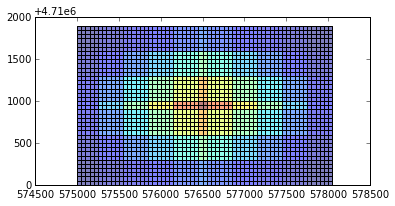

In [27]:
ax = bin_stats.plot(column="fold")

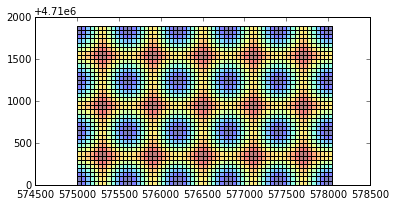

In [28]:
ax = bin_stats.plot(column="min_offset")

<hr />
## Dealing with the real world: moving stations

In [29]:
new_survey = gpd.GeoDataFrame.from_file('data/adjusted.shp')

Join the old survey to the new, based on SID. 

In [30]:
complete = pd.merge(survey, new_survey[['geometry', 'SID']], how='outer', on='SID')

Rename the columns.

In [31]:
complete.columns = ['geometry', 'station', 'SID', 'new_geometry']

In [32]:
complete[18:23]

,geometry,station,SID,new_geometry
18,POINT (576750 4710050),r,18,POINT (576750 4710050)
19,POINT (576850 4710050),r,19,POINT (576879.571706684 4710079.571706683)
20,POINT (576950 4710050),r,20,POINT (576950 4710050)
21,POINT (577050 4710050),r,21,POINT (577050 4710050)
22,POINT (577150 4710050),r,22,POINT (577150 4710050)


Calculate the distance each station has moved. We have to use `GeoSeries` to do this, and everything was transformed to ordinary `Series` when we did the join.

In [33]:
old = gpd.GeoSeries(complete.geometry)
new = gpd.GeoSeries(complete['new_geometry'])

complete['skid'] = old.distance(new)

In [34]:
complete[15:20]

,geometry,station,SID,new_geometry,skid
15,POINT (576450 4710050),r,15,POINT (576450 4710050),0.000000
16,POINT (576550 4710050),r,16,POINT (576550 4710050),0.000000
17,POINT (576650 4710050),r,17,POINT (576650 4710050),0.000000
18,POINT (576750 4710050),r,18,POINT (576750 4710050),0.000000
19,POINT (576850 4710050),r,19,POINT (576879.571706684 4710079.571706683),41.820709


Now that we have the new geometry, we can recompute everything, this time from the dataframe rather than from lists.

First the midpoints.

In [37]:
# we get a warning message in this block of code, but we can just ignore it.
import warnings
warnings.filterwarnings('ignore')

rcvrs = complete[complete['station']=='r'][complete['new_geometry'].notnull()]['new_geometry']
srcs = complete[complete['station']!='r'][complete['new_geometry'].notnull()]['new_geometry']

midpoint_list = [LineString([r, s]).interpolate(0.5, normalized=True)
                 for r in rcvrs
                 for s in srcs]

In [38]:
len(srcs)

124

In [40]:
offsets = [r.distance(s)
           for r in rcvrs
           for s in srcs]

In [41]:
azimuths = [np.arctan((r.x - s.x)/(r.y - s.y))
            for r in rcvrs
            for s in srcs]

In [42]:
new_midpoints = gpd.GeoDataFrame({'geometry': midpoint_list,
                                  'offset': offsets,
                                  'azimuth': np.degrees(azimuths),
                                  })

Now we can fill the bins and get the statistics.

In [43]:
new_stats = bin_the_midpoints(bins, new_midpoints).fillna(-1)

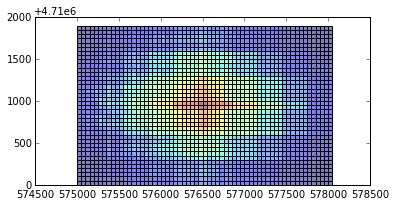

In [45]:
new_stats.plot(column="fold")
plt.show()

A quick diff shows how the fold has changed.

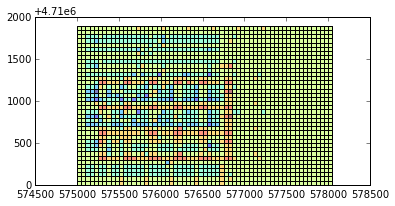

In [47]:
new_stats['diff'] = bin_stats.fold - new_stats.fold
new_stats.plot(column="diff")
plt.show()

In [58]:
# new_stats.to_file('data/new_stats.shp')

<hr />
<img src="https://avatars1.githubusercontent.com/u/1692321?v=3&s=200" style="float:right;" width="40px" /><p style="color:gray; float:right;">© 2015 <a href="http://www.agilegeoscience.com/">Agile Geoscience</a> — <a href="https://creativecommons.org/licenses/by/4.0/">CC-BY</a> — Have fun!&nbsp;&nbsp;&nbsp;</p>